In [10]:
import sqlite3
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import numpy as np

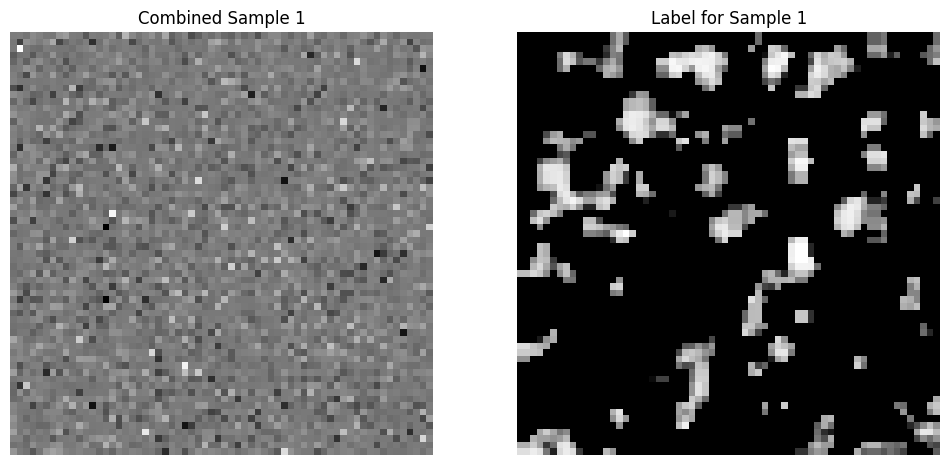

In [11]:
def visualize_combined_sample(db_path, sample_id, table_name='combined_arrays'):
    # Connect to the database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Fetch a single combined sample by ID
    cursor.execute(f'SELECT combined_data, label_data FROM {table_name} WHERE id=?', (sample_id,))
    combined_data, label_data = cursor.fetchone()
    
    # Deserialize the data
    combined_array = np.frombuffer(combined_data, dtype=np.float32).reshape((64, 64))
    label_array = np.frombuffer(label_data, dtype=np.float32).reshape((64, 64))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the combined array
    axes[0].imshow(combined_array, cmap='gray')
    axes[0].set_title(f"Combined Sample {sample_id}")
    axes[0].axis('off')
    
    # Plot the label array
    axes[1].imshow(label_array, cmap='gray')
    axes[1].set_title(f"Label for Sample {sample_id}")
    axes[1].axis('off')
    
    plt.show()
    
    conn.close()

# Visualize a sample
visualize_combined_sample('databases\combined_2D.db', sample_id=1)

In [12]:
def combined_data_generator(db_path, table_name='combined_arrays'):
    # Connect to the database
    conn = sqlite3.connect(db_path, check_same_thread=False)
    cursor = conn.cursor()
    
    # Fetch all combined data and labels
    cursor.execute(f'SELECT combined_data, label_data FROM {table_name}')
    
    for row in cursor:
        combined_data, label_data = row
        
        # Deserialize the data
        combined_array = np.frombuffer(combined_data, dtype=np.float32).reshape((64, 64))
        label_array = np.frombuffer(label_data, dtype=np.float32).reshape((64, 64))
        
        # Yield the combined array and the label array
        yield combined_array, label_array
    
    conn.close()

def create_tf_dataset(db_path, table_name='combined_arrays'):
    return tf.data.Dataset.from_generator(
        lambda: combined_data_generator(db_path, table_name),
        output_signature=(
            tf.TensorSpec(shape=(64, 64), dtype=tf.float32),  # Combined array shape and type
            tf.TensorSpec(shape=(64, 64), dtype=tf.float32)   # Label array shape and type
        )
    )



In [13]:
db_path = 'databases\combined_2D.db'  # Path to your combined database
dataset = create_tf_dataset(db_path)

# Example: Batch the dataset
batch_size = 32
dataset = dataset.batch(batch_size)

(32, 64, 64) (32, 64, 64)


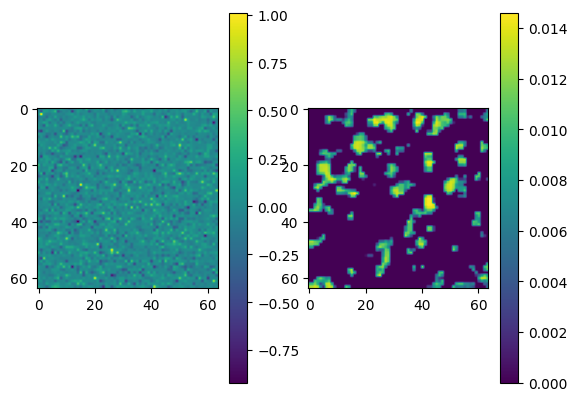

In [14]:
for combined_array, label_array in dataset.take(1):
    print(combined_array.shape, label_array.shape)
    plt.subplot(121)
    plt.imshow(combined_array[0,:,:])
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(label_array[0,:,:])
    plt.colorbar()
    plt.show()

In [15]:
'''shuffled_dataset = dataset.shuffle(buffer_size=1000)

total_samples = sum(1 for _ in dataset)
print(f"Total samples: {total_samples}")

train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size  # Ensure all samples are accounted for due to rounding

# Split the dataset
train_dataset = shuffled_dataset.take(train_size)
test_dataset = shuffled_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

train_samples = sum(1 for _ in train_dataset)
print(f"train_samples: {train_samples}")
test_samples = sum(1 for _ in test_dataset)
print(f"test_samples: {test_samples}")
val_samples = sum(1 for _ in val_dataset)
print(f"val_samples: {val_samples}")'''

'shuffled_dataset = dataset.shuffle(buffer_size=1000)\n\ntotal_samples = sum(1 for _ in dataset)\nprint(f"Total samples: {total_samples}")\n\ntrain_size = int(0.7 * total_samples)\nval_size = int(0.15 * total_samples)\ntest_size = total_samples - train_size - val_size  # Ensure all samples are accounted for due to rounding\n\n# Split the dataset\ntrain_dataset = shuffled_dataset.take(train_size)\ntest_dataset = shuffled_dataset.skip(train_size)\nval_dataset = test_dataset.skip(val_size)\ntest_dataset = test_dataset.take(test_size)\n\ntrain_samples = sum(1 for _ in train_dataset)\nprint(f"train_samples: {train_samples}")\ntest_samples = sum(1 for _ in test_dataset)\nprint(f"test_samples: {test_samples}")\nval_samples = sum(1 for _ in val_dataset)\nprint(f"val_samples: {val_samples}")'

In [16]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Input, MaxPooling2D, Dropout
from tensorflow.keras.models import Model


lrelu = LeakyReLU()


def decoder_block(input_tensor, skip_features, n_filters, kernel_size=(3,3), batch_norm=True):
    # Transposed convolution (upsampling)
    x = Conv2DTranspose(n_filters, kernel_size, strides=(2, 2), padding='same')(input_tensor)
    # Concatenate with the corresponding output of the encoder (skip connection)
    x = concatenate([x, skip_features])
    # Convolutional layers with batch normalization and activation
    x = Conv2D(n_filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(lrelu)(x)

    x = Conv2D(n_filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(lrelu)(x)

    return x

In [17]:

def build_unet(input_shape=(64, 64, 1), n_filters=64, batch_norm=True):
    inputs = Input(input_shape)

    # Encoder: contracting path
    c1 = Conv2D(n_filters, (3, 3), activation=lrelu, padding='same')(inputs)
    c1 = Conv2D(n_filters, (3, 3), activation=lrelu, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(n_filters*2, (3, 3), activation=lrelu, padding='same')(p1)
    c2 = Conv2D(n_filters*2, (3, 3), activation=lrelu, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(n_filters*4, (3, 3), activation=lrelu, padding='same')(p2)
    c3 = Conv2D(n_filters*4, (3, 3), activation=lrelu, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(n_filters*8, (3, 3), activation=lrelu, padding='same')(p3)
    c4 = Conv2D(n_filters*8, (3, 3), activation=lrelu, padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(n_filters*12, (3, 3), activation=lrelu, padding='same')(p4)
    c5 = Conv2D(n_filters*12, (3, 3), activation=lrelu, padding='same')(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    c6 = Conv2D(n_filters*16, (3, 3), activation=lrelu, padding='same')(p5)
    c6 = Conv2D(n_filters*16, (3, 3), activation=lrelu, padding='same')(c6)

    # Decoder: expansive path
    d7 = decoder_block(c6, c5, n_filters*12, batch_norm=batch_norm)
    d8 = decoder_block(d7, c4, n_filters*8, batch_norm=batch_norm)
    d9 = decoder_block(d8, c3, n_filters*4, batch_norm=batch_norm)
    d10 = decoder_block(d9, c2, n_filters*2, batch_norm=batch_norm)
    d11 = decoder_block(d10, c1, n_filters, batch_norm=batch_norm)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d11)

    # Model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build U-Net model
unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [18]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 64, 64, 64)           640       ['input_2[0][0]']             
                                                                                                  
 conv2d_24 (Conv2D)          (None, 64, 64, 64)           36928     ['conv2d_23[0][0]']           
                                                                                                  
 max_pooling2d_5 (MaxPoolin  (None, 32, 32, 64)           0         ['conv2d_24[0][0]']           
 g2D)                                                                                       

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
callbacks = [
    ModelCheckpoint('model-unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

history = unet_model.fit(
    train_dataset,
    epochs=500,
    #steps_per_epoch=(train_samples // batch_size),
    validation_data=val_dataset,
    #validation_steps=(val_samples // batch_size),
    callbacks=callbacks
)

Epoch 1/500


   5470/Unknown - 2784s 507ms/step - loss: 0.0010 - accuracy: 0.7845
Epoch 1: val_loss improved from inf to 0.00002, saving model to model-unet.h5
5470/5470 [==============================] - 2963s 539ms/step - loss: 0.0010 - accuracy: 0.7845 - val_loss: 1.8370e-05 - val_accuracy: 0.7838
Epoch 2/500
5470/5470 [==============================] - ETA: 0s - loss: 1.6897e-05 - accuracy: 0.7844
Epoch 2: val_loss improved from 0.00002 to 0.00002, saving model to model-unet.h5
5470/5470 [==============================] - 3255s 594ms/step - loss: 1.6897e-05 - accuracy: 0.7844 - val_loss: 1.6711e-05 - val_accuracy: 0.7838
Epoch 3/500
5470/5470 [==============================] - ETA: 0s - loss: 1.6513e-05 - accuracy: 0.7843
Epoch 3: val_loss improved from 0.00002 to 0.00002, saving model to model-unet.h5
5470/5470 [==============================] - 3480s 635ms/step - loss: 1.6513e-05 - accuracy: 0.7843 - val_loss: 1.6187e-05 - val_accuracy: 0.7847
Epoch 4/500
5470/5470 [==========================

KeyboardInterrupt: 

1/1 [==============================] - 1s 669ms/step


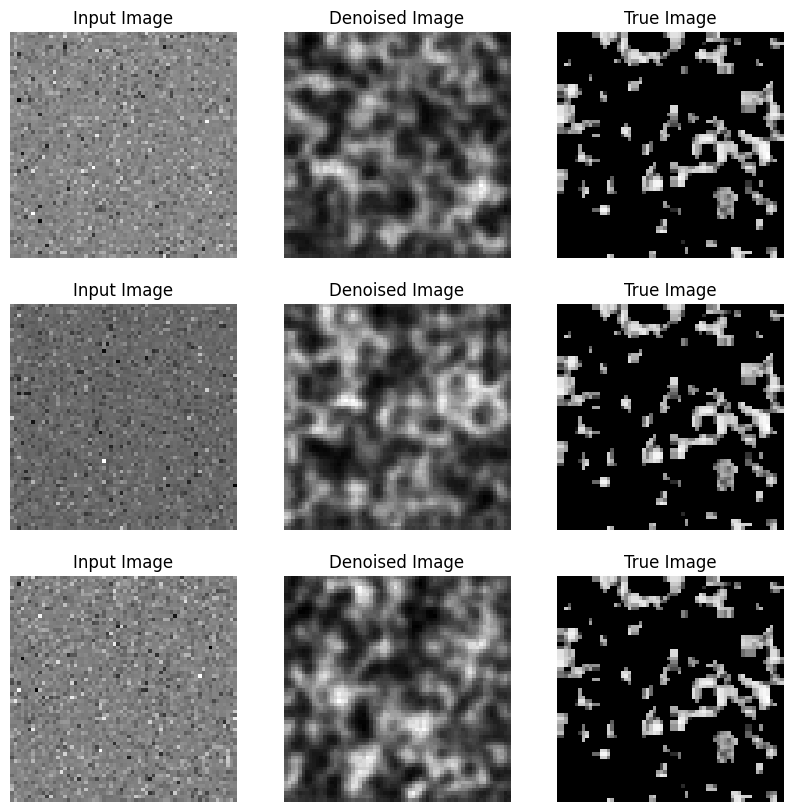

In [11]:
for test_images, test_labels in test_dataset.take(1):
    predictions = unet_model.predict(test_images)
    plt.figure(figsize=(10, 10))
    for i in range(3):  # Display a few images from the batch
        plt.subplot(3, 3, i*3+1)
        plt.imshow(test_images[i].numpy().squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')
        
        plt.subplot(3, 3, i*3+2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')
        
        plt.subplot(3, 3, i*3+3)
        plt.imshow(test_labels[i].numpy().squeeze(), cmap='gray')
        plt.title("True Image")
        plt.axis('off')
    plt.show()

In [ ]:

'''def build_unet_model(input_shape=(64, 64, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Contracting Path (Encoder)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive Path (Decoder)
    u6 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1], axis=3)
    c7 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model





# Create the U-Net model
unet_model = build_unet_model()
unet_model.compile(optimizer='adam', loss='mean_squared_error')'''

"def build_unet_model(input_shape=(64, 64, 1)):\n    inputs = tf.keras.Input(shape=input_shape)\n    \n    # Contracting Path (Encoder)\n    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)\n    c1 = layers.Dropout(0.1)(c1)\n    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)\n    p1 = layers.MaxPooling2D((2, 2))(c1)\n    \n    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)\n    c2 = layers.Dropout(0.1)(c2)\n    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)\n    p2 = layers.MaxPooling2D((2, 2))(c2)\n    \n    # Bottleneck\n    c5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)\n    c5 = layers.Dropout(0.2)(c5)\n    c5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)\n 

In [ ]:
'''history = unet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1  # Adjust the number of epochs based on your needs
)'''

'history = unet_model.fit(\n    train_dataset,\n    validation_data=val_dataset,\n    epochs=1  # Adjust the number of epochs based on your needs\n)'

In [ ]:

'''for test_images, test_labels in test_dataset.take(1):
    predictions = unet_model.predict(test_images)
    plt.figure(figsize=(10, 10))
    for i in range(3):  # Display a few images from the batch
        plt.subplot(3, 3, i*3+1)
        plt.imshow(test_images[i].numpy().squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')
        
        plt.subplot(3, 3, i*3+2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')
        
        plt.subplot(3, 3, i*3+3)
        plt.imshow(test_labels[i].numpy().squeeze(), cmap='gray')
        plt.title("True Image")
        plt.axis('off')
    plt.show()'''

'for test_images, test_labels in test_dataset.take(1):\n    predictions = unet_model.predict(test_images)\n    plt.figure(figsize=(10, 10))\n    for i in range(3):  # Display a few images from the batch\n        plt.subplot(3, 3, i*3+1)\n        plt.imshow(test_images[i].numpy().squeeze(), cmap=\'gray\')\n        plt.title("Input Image")\n        plt.axis(\'off\')\n        \n        plt.subplot(3, 3, i*3+2)\n        plt.imshow(predictions[i].squeeze(), cmap=\'gray\')\n        plt.title("Denoised Image")\n        plt.axis(\'off\')\n        \n        plt.subplot(3, 3, i*3+3)\n        plt.imshow(test_labels[i].numpy().squeeze(), cmap=\'gray\')\n        plt.title("True Image")\n        plt.axis(\'off\')\n    plt.show()'